# Science des données
# TP 5 
## Séparateur à Vaste Marge et Méthode à Noyaux


## Machines à Vecteurs de Support (SVM)

On commence par (essayer... d') installer un module qui permet de plus jolies visualisation que le matplotlib de base:

In [1]:
!/opt/anaconda3/bin/pip install seaborn --user

Sistem belirtilen yolu bulamıyor.


## Première partie : prise en main des SVM
Cette partie est librement inspirée du travail de Jake VenderPlas, auteur du livre [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do). Son [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook) (en anglais) regorge de fichiers utiles.

Dans un premier temps, on va générer des données jouets, linéairement séparables :

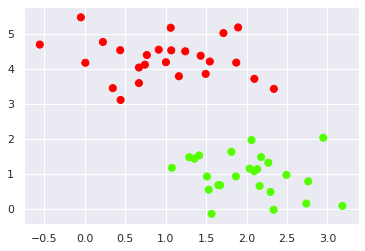

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

#Un petit environment qui donne de meilleurs graphes
import seaborn as sns; sns.set()

# fonction sklearn pour générer des données simples
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

# Affichage des données
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism');

### SVM linéaire (=perceptron à vaste marge)
On va commencer par apprendre un SVM sans noyau (on dit "linéaire") à l'aide de scikit-learn :

In [2]:
#import de la classe - qui s'appelle SVC et pas SVM...
from sklearn.svm import SVC
#Définition du modèle
model = SVC(kernel='linear', C=1E10)
#Apprentissage sur les donnée
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

On va utiliser une fonction d'affichage qui va bien, où tout ce qui est nécessaire est affiché. Il ne faut pas forcément la comprendre complètement de suite car on reviendra plus bas sur les points importants.

In [3]:
import numpy as np

def affiche_fonction_de_decision(model, ax=None, plot_support=True):
    """Affiche le séparateur, les marges, et les vecteurs de support d'un SVM en 2D"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # création de la grille pour l'évaluation
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # affichage de l'hyperplan et des marges
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # Affichage des vecteurs de support
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolor='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Voyons ce que cela donne sur notre séparateur linéaire à vaste marge :

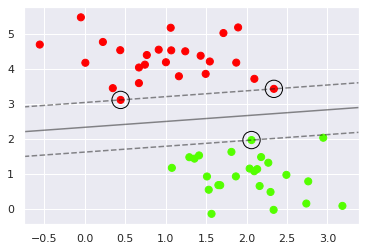

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')
affiche_fonction_de_decision(model);

Sur ce graphe, on voit le séparateur (ligne pleine), les vecteurs de support (points entourés) et la marge (matérialisée par des lignes discontinues).
On a ici le séparateur qui maximise la marge.
Scikit-learn nous permet, après apprentissage, de récupérer les vecteurs de supports:

In [5]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Seuls trois données sont utiles pour classer de nouvelles données. On peut s'en assurer en rajoutant des données sans changer le modèle :


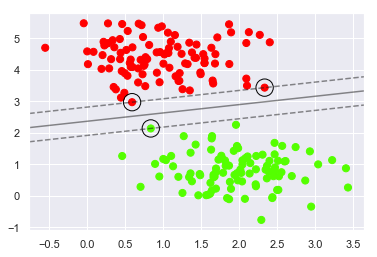

In [6]:
X2, y2 = make_blobs(n_samples=200, centers=2,
                  random_state=0, cluster_std=0.60)

model2 = SVC(kernel='linear', C=1E10)
model2.fit(X2, y2)

plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='prism')
affiche_fonction_de_decision(model2);

### SVM non linéaire
Comme on l'a vu ce matin, la puissance des séparateurs linéaires est limitée (à des données linéairement séparables). Mais il est possible de contourner cette limitation par l'utilisation de noyaux.

On va commencer par générer des données non-linéairement séparables :

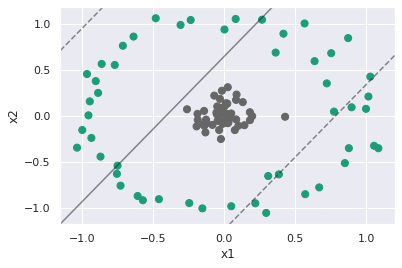

In [6]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='Dark2')
plt.xlabel('x1')
plt.ylabel('x2')
affiche_fonction_de_decision(clf, plot_support=False)

Clairement notre apprentissage de séparateur linéaire a échoué...

On va manuellement ajouter une troisième dimension *z* :

In [8]:
z = np.exp(-(X ** 2).sum(1))

On peut afficher les données augmentées et se rendre compte qu'elles sont linéairement séparables :

Text(0.5,0,'z')

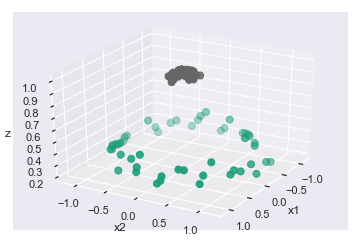

In [9]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], z, c=y, s=50, cmap='Dark2')
ax.view_init(elev=30, azim=30)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('z')

Le plan définit par z=0.7 (par exemple) sépare les 2 classes parfaitement.

Bien entendu, la projection en plus grande dimension est capitale, et en choisissant un autre calcul pour *z* on aurait obtenu dans la plupart des cas des données non linéairement séparables.

Et s'il fallait faire effectivement la projection, cela limiterait drastiquement la dimension de l'espace de plongement ainsi que le nombre de données traitables. C'est pourquoi l'utilisation de noyaux (kernels en anglais) est d'une grande efficacité.

En Scikit-Learn, il suffit de modifier le paramètre *kernel* : jusqu'à présent, nous avons utilisé 'linear' comme valeur. On peut par exemple utiliser *rbf* pour 'radial basis function', le noyau gaussien, et il nous reste à trouver la bonne valeur du paramètre :

In [10]:
clf = SVC(kernel='rbf', gamma='auto', C=1E10)
clf.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

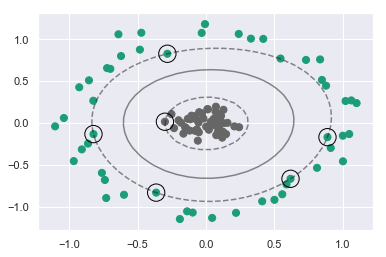

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='Dark2')
affiche_fonction_de_decision(clf) 

On voit ici que le séparateur (et la marge associée) ne sont pas linéaire dans l'espace des données, mais qu'ils peuvent s'y représenter sans difficulté.

Notons aussi que le nombre de vecteurs de support reste très petit.

### SVM à marge douce

Il est aussi possible que le problème soit linéairement séparable (dans la dimension initiale des données ou dans un plongement) mais que le bruit (=la mauvaise qualité des données) empêche l'apprenant de trouver un séparateur.

On utilise alors ce que l'on appelle un classifieur à marge douce : on autorise alors certains points à être dans la marge. C'est le role du paramètre *C* : pour des grosses valeurs, on est quasiment en marge dure, mais plus *C* prend des petites valeurs, plus les marges deviennent permissibles.

On va prendre des données qui se chevauchent un peu :

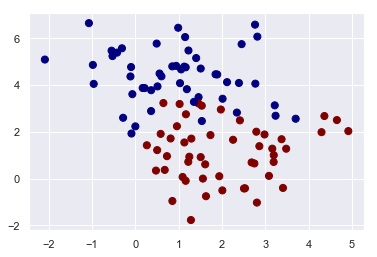

In [12]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet');

On joue alors avec la valeur de *C*

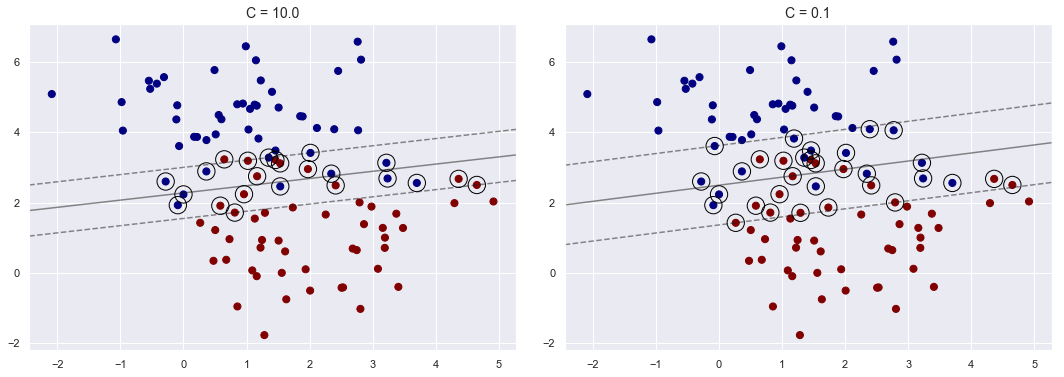

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
    affiche_fonction_de_decision(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Bien entendu, il est possible de combiner l'utilisation d'un noyau et de marges douces.

### Tuner un SVM
Tous les noyaux sont paramétrés : il est question ici d'étudier l'impact d'un (hyper)paramètre sur la qualité de l'apprentissage.
On va générer des données qui ne sont pas linéairement séparables :

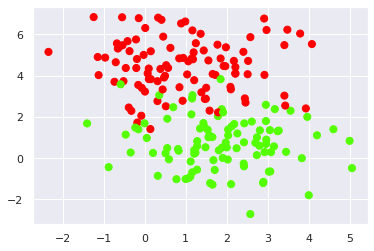

In [7]:
X, y = make_blobs(n_samples=200, centers=2,
                  random_state=0, cluster_std=1.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')

On va étudier 2 noyaux différents
- le noyau polynomial (*kernel='poly'*) qui a 2 paramètres, *degree* qu'il faut faire varier entre 2 et 6 (au minimum), et *C* (lié à la 'douceur' de la marge)
- le noyau gaussien (*kernel='rbf'*) qui a aussi 2 paramètres, *gamma*, qu'il faut faire varier de 10 à 0.001, et *C* 

A chaque fois, en plus de l'affichage des séparateurs, il serait intéressant de regarder combien de vecteurs de support le classifieur appris a besoin.

A vous de jouer !


In [ ]:
# A vous
clf = SVC(kernel='poly', gamma='auto', degree=3, C=1E10)
clf.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')
affiche_fonction_de_decision(clf) 
print("Nombre de vecteurs de support (sur 200 données) :", len(clf.support_vectors_))

Nombre de vecteurs de support (sur 200 données) : 31


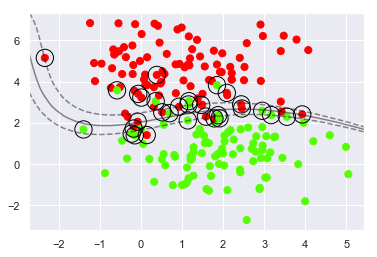

In [16]:
###
#Exemple avec le noyau gaussien et des valeurs pour gamma et C
clf = SVC(kernel='rbf', gamma=0.001, C=1E7)
clf.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')
affiche_fonction_de_decision(clf) 
print("Nombre de vecteurs de support (sur 200 données) :", len(clf.support_vectors_))

## Deuxième partie : un traitement (presque) complet
### Préparation des données
Nous allons utiliser un jeu de données réel - tiré de *Tsanas & Xifara : Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools, Energy and Buildings, Vol. 49, pp. 560-567, 2012* - qu'il vous faut d'abord télécharger :

In [17]:
!wget http://pageperso.lif.univ-mrs.fr/~remi.eyraud/data.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


Les 8 premières colonnes correspondent aux attributs descriptifs et les deux dernières, aux charges de chauffage et de climatisation (dans cet ordre).
Pour les utiliser en Python, vous pourrez vous servir du code suivant :

In [4]:
data = np.loadtxt("./data.csv")
X = data[:,:-2]
Y = data[:,-2:]
Yheat = Y[:,0]
Ycool = Y[:,1]
print(Y)

[[15.55 21.33]
 [15.55 21.33]
 [15.55 21.33]
 ...
 [16.44 17.11]
 [16.48 16.61]
 [16.64 16.03]]


Le problème initial, tel que présenté ici, est un problème de régression. Nous allons d'abord le transformer en problème de classification. Par une méthode de clustering, on veut répartir les charges de chauffage et de climatisation en 3 classes : faibles, moyennes, élevées.

A vous de jouer :

In [5]:
from sklearn.cluster import KMeans
# La suite ? il s'agit de définir un classifieur du k-means avec k=3 
# et d'utiliser la méthode 'fit' sur les 2 ensembles de valeurs Y
Yheat_vector = Yheat.reshape(-1,1)

kmeans = KMeans(n_clusters=3, random_state=0).fit(Y)
Y = kmeans.labels_

# Le seul trick : les Y sont des vecteurs et les classifieurs sklearn ont besoin d'array :
# il faut les reshaper : Yheat_vector = Yheat.reshape(-1,1)

# Après apprentissage du kmeans, les classes des données utilisées sont stockées dans mon_classifieur.labels_

### Apprentissage
Nous voulons comparer plusieurs méthodes d'apprentissage :
1. Les k-plus proches voisins (*KNeighborsClassifier* de la classe *sklearn.neighbors*, hyperparamètre à régler : *n_neighbors*)
2. Les arbres de décision  (*DecisionTreeClassifier* de la classe *sklearn.tree*, hyperparamètre à régler : *max_depth*)
3. Perceptron linéaire (*Perceptron* de la classe *sklearn.linear_model*, hyperparamètre à régler : aucun/*max_iter* en sklearn 0.19 ou plus récent)
4. SVM à noyau gaussien  (*SVC* avec *kernel='rbf'* de la classe *sklearn.svm*, hyperparamètre à régler : *gamma*)
5. SVM à noyau polynomial (*SVC* avec *kernel='poly'* de la classe *sklearn.svm*, hyperparamètre à régler : *degree*)

Ecrivez le code permettant de :
1. Séparer les données en un échantillon d'apprentissage et un échantillon de test (80/20)
2. Sélectionner les meilleurs valeurs des hyperparamètres sur l'échantillon d'apprentissage par validation croisée en utilisant 10 folders

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT

# A vous
def cross_validation(clf, Xtrain, ytrain, fold=10):
    reussite = cross_val_score(clf, X_train, y_train, cv = 10)
    #f1 = cross_val_score(knn_clf, X_train, y_train, cv = 10, scoring='f1_macro')
    #print("Pour Knn n_neighbors=%d :\n \t taux de réussite : %f (+/-) %f\n \
    #          \t F-score (global) : %f (+/-) %f\n " 
    #          %(n, reussite.mean(), reussite.std(), f1.mean(), f1.std()) )
    return reussite.mean()
    
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

#KNeighborsClassifier
best_n_for_knn = 0
best_score = 0
for n in range (2, 20):
    knn_clf = KNN(n_neighbors = n) 
    knn_clf.fit(X_train,y_train)
    score = cross_validation(knn_clf, X_train, y_train)
    if(best_score < score):
        best_n_for_knn = n
        best_score = score

print("best n_neighbors for Knn = {}".format(best_n_for_knn))

#DecisionTreeClassifier
best_md_for_dt = 0
best_score = 0
for md in range (5, 20):
    dt_clf = DT(max_depth= md) 
    dt_clf.fit(X_train,y_train)
    score = cross_validation(dt_clf, X_train, y_train)
    if(best_score < score):
        best_md_for_dt = md
        best_score = score

print("best max_depth for DecisionTree = {}".format(best_md_for_dt))

#Perceptron


#SVC avec kernel='rbf' 
best_gm_for_svc_gaus = 0
best_score = 0
A = np.array([1e-09, 1e-08, 1e-07, 1e-06, 1e-05])
for gm in A:
    svc_gaus_clf = SVC(kernel='rbf', gamma=gm )
    svc_gaus_clf.fit(X_train,y_train)
    score = cross_validation(svc_gaus_clf, X_train, y_train)
    if(best_score < score):
        best_gm_for_svc_gaus = gm
        best_score = score

print("best gamma for SVM rbf = {}".format(best_gm_for_svc_gaus))


#SVC avec kernel='poly' 
best_dg_for_svc_poly = 0
best_score = 0
for dg in range (1, 2):
    svc_poly_clf = SVC(kernel='poly', gamma='auto', degree=dg)
    svc_poly_clf.fit(X_train,y_train)
    score = cross_validation(svc_poly_clf, X_train, y_train)
    if(best_score < score):
        best_dg_for_svc_poly = dg
        best_score = score

print("best degree for SVM poly = {}".format(best_dg_for_svc_poly))

### Analyse des résultats
Afficher sur une courbe les scores de chacun des algorithmes avec la meilleure valeur d'hyperparamètre possible sur l'échantillon de test.

In [ ]:
# A vous

Pour chacune des méthodes, pour chaque meilleur hyperparamètre, calculer l'intervalle à 95% de confiance auquel le score doit appartenir en utilisant les résultats de la validation croisée. Si vous ne vous souvenez plus de comment on calcule un interval de confiance, vous pouvez consulter : https://fr.wikihow.com/calculer-un-intervalle-de-confiance

In [ ]:
# A vous

Quelle méthodes est la meilleure pour prédire la classe de frais de chauffage ? De frais de climatisation ?